#### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Classification on imbalanced data

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/imbalanced_data"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to classify a highly imbalanced dataset in which the number of examples in one class greatly outnumbers the examples in another. You will work with the [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset hosted on Kaggle. The aim is to detect a mere 492 fraudulent transactions from 284,807 transactions in total. You will use [Keras](../../guide/keras/overview.ipynb) to define the model and [class weights](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model) to help the model learn from the imbalanced data. You will display metrics for precision, recall, true positives, false positives, true negatives, false negatives, and AUC while training the model. These are more informative than accuracy when working with imbalanced datasets classification.

This tutorial contains complete code to:

* Load a CSV file using Pandas.
* Create train, validation, and test sets.
* Define and train a model using Keras (including setting class weights).
* Evaluate the model using various metrics (including precision and recall).

## Import TensorFlow and other libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

!pip install -q imblearn

In [3]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score, average_precision_score

from imblearn.over_sampling import SMOTE, RandomOverSampler

In [4]:
"""
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""
"""

my_devices = tf.config.experimental.list_physical_devices()
print(my_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Use Pandas to get the Kaggle Credit Card Fraud data set

Pandas is a Python library with many helpful utilities for loading and working with structured data and can be used to download CSVs into a dataframe.

Note: This dataset has been collected and analysed during a research collaboration of Worldline and the [Machine Learning Group](http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available [here](https://www.researchgate.net/project/Fraud-detection-5) and the page of the [DefeatFraud](https://mlg.ulb.ac.be/wordpress/portfolio_page/defeatfraud-assessment-and-validation-of-deep-feature-engineering-and-learning-solutions-for-fraud-detection/) project

In [5]:
# raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df = pd.read_csv("/home/yannick/.kaggle/creditcard.csv")
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Split the dataframe into train, validation, and test

Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where [overfitting](https://developers.google.com/machine-learning/crash-course/generalization/peril-of-overfitting) is a significant concern from the lack of training data.

In [6]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(raw_df, test_size=0.3, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

# Normalize the input features using the sklearn StandardScaler.
# This will set the mean to 0 and standard deviation to 1.
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (179427,)
Validation labels shape: (19937,)
Test labels shape: (85443,)
Training features shape: (179427, 30)
Validation features shape: (19937, 30)
Test features shape: (85443, 30)


## Examine the class label imbalance

Let's look at the dataset imbalance:

In [7]:
neg, pos = np.bincount(train_labels)
total = neg + pos
print('{} positive samples out of {} training samples ({:.2f}% of total)'.format(
    pos, total, 100 * pos / total))

319 positive samples out of 179427 training samples (0.18% of total)


This shows a small fraction of positive samples.

## Define the model and metrics

Define a function that creates a simple neural network with three densely connected hidden layers, an output sigmoid layer that returns the probability of a transaction being fraudulent, and two [dropout](https://developers.google.com/machine-learning/glossary/#dropout_regularization) layers as an effective way to reduce overfitting.

In [8]:
def make_model():
  model = keras.Sequential([
      keras.layers.Dense(512, activation='relu',
                         input_shape=(train_features.shape[-1],)),
      keras.layers.Dense(256, activation='relu'),
      keras.layers.Dropout(0.4),
      keras.layers.Dense(256, activation='relu'),
      keras.layers.Dropout(0.4),
      keras.layers.Dense(1, activation='sigmoid'),
  ])

  metrics = [
      keras.metrics.Accuracy(name='accuracy'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
  ]

  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=metrics)
  
  return model

## Understanding useful metrics

Notice that there are a few metrics defined above that can be computed by the model that will be helpful when evaluating the performance.



*   **False** negatives and **false** positives are samples that were **incorrectly** classified
*   **True** negatives and **true** positives are samples that were **correctly** classified
*   **Accuracy** is the percentage of examples correctly classified
>   $\frac{\text{true samples}}{\text{total samples}}$
*   **Precision** is the percentage of **predicted** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false positives}}$
*   **Recall** is the percentage of **actual** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false negatives}}$
*   **AUC** refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than than a random negative sample.

<br>

Read more:
*  [True vs. False and Positive vs. Negative](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative)
*  [Accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy)
*   [Precision and Recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
*   [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)

## Train a baseline model

Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudelent transactions to learn from.


Note: this model will not handle the class imbalance well. You will improve it later in this tutorial.

In [11]:
%%time

model = make_model()

EPOCHS = 40
BATCH_SIZE = 2048

history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_features, val_labels),
    verbose=0)

y_hat = model.predict_proba(test_features)
print("test score = %.3f" % average_precision_score(test_labels, y_hat))

test score = 0.848
CPU times: user 42 s, sys: 2.66 s, total: 44.6 s
Wall time: 30.6 s


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               15872     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 213,249
Trainable params: 213,249
Non-trainable params: 0
__________________________________________________

## Plot metrics on the training and validation sets
In this section, you will produce plots of your model's accuracy and loss on the training and validation set. These are useful to check for overfitting, which you can learn more about in this [tutorial](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

Additionally, you can produce these plots for any of the metrics you created above. False negatives are included as an example.

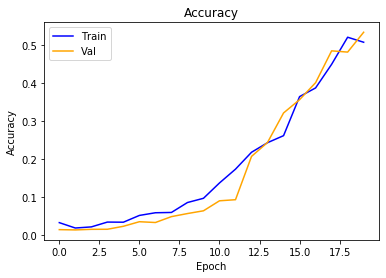

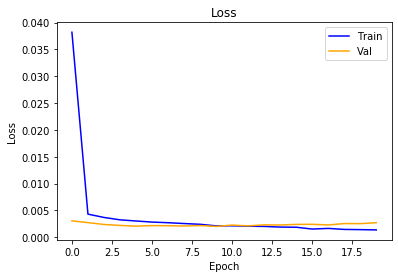

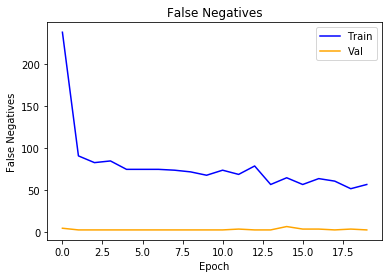

In [12]:
epochs = range(EPOCHS)

plt.title('Accuracy')
plt.plot(epochs,  history.history['accuracy'], color='blue', label='Train')
plt.plot(epochs, history.history['val_accuracy'], color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

_ = plt.figure()
plt.title('Loss')
plt.plot(epochs, history.history['loss'], color='blue', label='Train')
plt.plot(epochs, history.history['val_loss'], color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

_ = plt.figure()
plt.title('False Negatives')
plt.plot(epochs, history.history['fn'], color='blue', label='Train')
plt.plot(epochs, history.history['val_fn'], color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('False Negatives')
plt.legend()

## Evaluate the baseline model

Evaluate your model on the test dataset and display results for the metrics you created above.

In [13]:
results = model.evaluate(test_features, test_labels, verbose=2)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)

85443/1 - 14s - loss: 0.0015 - accuracy: 0.5401 - tp: 113.0000 - fp: 14.0000 - tn: 85293.0000 - fn: 23.0000 - precision: 0.8898 - recall: 0.8309 - auc: 0.9482
loss :  0.0029589861004233452
accuracy :  0.5401379
tp :  113.0
fp :  14.0
tn :  85293.0
fn :  23.0
precision :  0.8897638
recall :  0.8308824
auc :  0.9482409


It looks like the precision is relatively high, but the recall and AUC aren't as high as you might like. Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with imbalanced datasets. However, because missing fraudulent transactions (false negatives) may have significantly worse business consequences than incorrectly flagging fraudulent transactions (false positives), recall may be more important than precision in this case.

## Examine the confusion matrix

You can use a [confusion matrix](https://developers.google.com/machine-learning/glossary/#confusion_matrix) to summarize the actual vs. predicted labels where the X axis is the predicted label and the Y axis is the actual label.

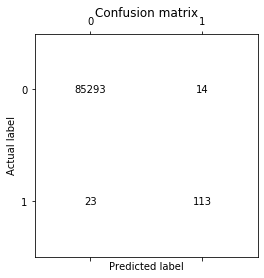

Legitimate Transactions Detected (True Negatives):  85293
Legitimate Transactions Incorrectly Detected (False Positives):  14
Fraudulent Transactions Missed (False Negatives):  23
Fraudulent Transactions Detected (True Positives):  113
Total Fraudulent Transactions:  136


In [14]:
predicted_labels = model.predict(test_features)
cm = confusion_matrix(test_labels, np.round(predicted_labels))

plt.matshow(cm, alpha=0)
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, str(z), ha='center', va='center')
    
plt.show()

print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
print('Total Fraudulent Transactions: ', np.sum(cm[1]))

If the model had predicted everything perfectly, this would be a [diagonal matrix](https://en.wikipedia.org/wiki/Diagonal_matrix) where values off the main diagonal, indicating incorrect predictions, would be zero. In this case the matrix shows that you have relatively few false positives, meaning that there were relatively few legitimate transactions that were incorrectly flagged. However, you would likely want to have even fewer false negatives despite the cost of increasing the number of false positives. This trade off may be preferable because false negatives would allow fraudulent transactions to go through, whereas false positives may cause an email to be sent to a customer to ask them to verify their card activity.

## Using class weights for the loss function

The goal is to identify fradulent transactions, but you don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [15]:

weight_for_0 = 1 / neg
weight_for_1 = 1 / pos

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2e}'.format(weight_for_0))
print('Weight for class 1: {:.2e}'.format(weight_for_1))

Weight for class 0: 5.58e-06
Weight for class 1: 3.13e-03


## Train a model with class weights

Now try re-training and evaluating the model with class weights to see how that affects the predictions.

Note: Using `class_weights` changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers who's step size is dependent on the magnitude of the gradient, like `optimizers.SGD`, may fail. The optimizer used here, `optimizers.Adam`, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [16]:
weighted_model = make_model()

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_features, val_labels),
    class_weight=class_weight)

y_hat = weighted_model.predict_proba(test_features)
print("test score = %.3f" % average_precision_score(test_labels, y_hat))

Train on 179427 samples, validate on 19937 samples
Epoch 1/20
179427/179427 [==============================] - 4s 23us/sample - loss: 5.0033e-06 - accuracy: 1.1147e-05 - tp: 293.0000 - fp: 79426.0000 - tn: 99682.0000 - fn: 26.0000 - precision: 0.0037 - recall: 0.9185 - auc: 0.9144 - val_loss: 2.8265e-06 - val_accuracy: 0.0000e+00 - val_tp: 34.0000 - val_fp: 109.0000 - val_tn: 19791.0000 - val_fn: 3.0000 - val_precision: 0.2378 - val_recall: 0.9189 - val_auc: 0.9743
Epoch 2/20
179427/179427 [==============================] - 1s 5us/sample - loss: 2.9719e-06 - accuracy: 1.2261e-04 - tp: 271.0000 - fp: 2518.0000 - tn: 176590.0000 - fn: 48.0000 - precision: 0.0972 - recall: 0.8495 - auc: 0.9453 - val_loss: 1.6953e-06 - val_accuracy: 4.5142e-04 - val_tp: 35.0000 - val_fp: 301.0000 - val_tn: 19599.0000 - val_fn: 2.0000 - val_precision: 0.1042 - val_recall: 0.9459 - val_auc: 0.9873
Epoch 3/20
179427/179427 [==============================] - 1s 5us/sample - loss: 2.1334e-06 - accuracy: 3.0653e

In [17]:
weighted_results = weighted_model.evaluate(test_features, test_labels, verbose=2)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)

85443/1 - 16s - loss: 0.0510 - accuracy: 0.0186 - tp: 128.0000 - fp: 3072.0000 - tn: 82235.0000 - fn: 8.0000 - precision: 0.0400 - recall: 0.9412 - auc: 0.9802
loss :  0.09768208743013762
accuracy :  0.018597193
tp :  128.0
fp :  3072.0
tn :  82235.0
fn :  8.0
precision :  0.04
recall :  0.9411765
auc :  0.9802051


Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives. Despite having lower overall accuracy, this approach may be better when considering the consequences of failing to identify fraudulent transactions driving the prioritization of recall. Depending on how bad false negatives are, you might use even more exaggerated weights to further improve recall while dropping precision.

## Oversampling the minority class

A related approach would be to resample the dataset by oversampling the minority class, which is the process of creating more positive samples using something like sklearn's [imbalanced-learn library](https://github.com/scikit-learn-contrib/imbalanced-learn). This library provides methods to create new positive samples by simply duplicating random existing samples, or by interpolating between them to generate synthetic samples using variations of [SMOTE](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#Oversampling_techniques_for_classification_problems). TensorFlow also provides a way to do [Random Oversampling](https://www.tensorflow.org/api_docs/python/tf/data/experimental/sample_from_datasets).

In [18]:
# with default args this will oversample the minority class to have an equal
# number of observations
smote = SMOTE()
res_features, res_labels = smote.fit_sample(train_features, train_labels)

smote = RandomOverSampler(0.5)
res_features, res_labels = smote.fit_sample(train_features, train_labels)


res_neg, res_pos = np.bincount(res_labels)
res_total = res_neg + res_pos
print('{} positive samples out of {} training samples ({:.2f}% of total)'.format(
    res_pos, res_total, 100 * res_pos / res_total))

89554 positive samples out of 268662 training samples (33.33% of total)


## Train and evaluate a model on the resampled data

Now try training the model with the resampled data set instead of using class weights to see how these methods compare.

In [19]:
resampled_model = make_model()

resampled_history = resampled_model.fit(
    res_features,
    res_labels,
    batch_size=64,
    epochs=EPOCHS,
    validation_data=(val_features, val_labels))

y_hat = resampled_model.predict_proba(test_features)
print("test score = %.3f" % average_precision_score(test_labels, y_hat))

Train on 268662 samples, validate on 19937 samples
Epoch 1/20
268662/268662 [==============================] - 34s 125us/sample - loss: 0.0211 - accuracy: 0.5616 - tp: 88788.0000 - fp: 898.0000 - tn: 178210.0000 - fn: 766.0000 - precision: 0.9900 - recall: 0.9914 - auc: 0.9994 - val_loss: 0.0130 - val_accuracy: 0.6190 - val_tp: 34.0000 - val_fp: 59.0000 - val_tn: 19841.0000 - val_fn: 3.0000 - val_precision: 0.3656 - val_recall: 0.9189 - val_auc: 0.9718
Epoch 2/20
268662/268662 [==============================] - 31s 116us/sample - loss: 0.0079 - accuracy: 0.6338 - tp: 89428.0000 - fp: 293.0000 - tn: 178815.0000 - fn: 126.0000 - precision: 0.9967 - recall: 0.9986 - auc: 0.9997 - val_loss: 0.0072 - val_accuracy: 0.7926 - val_tp: 34.0000 - val_fp: 17.0000 - val_tn: 19883.0000 - val_fn: 3.0000 - val_precision: 0.6667 - val_recall: 0.9189 - val_auc: 0.9590
Epoch 3/20
268662/268662 [==============================] - 31s 116us/sample - loss: 0.0057 - accuracy: 0.6877 - tp: 89446.0000 - fp: 212

In [20]:
resampled_results = resampled_model.evaluate(test_features, test_labels, verbose=2)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)

85443/1 - 7s - loss: 0.0144 - accuracy: 0.9953 - tp: 117.0000 - fp: 61.0000 - tn: 85246.0000 - fn: 19.0000 - precision: 0.6573 - recall: 0.8603 - auc: 0.9372
loss :  0.028710401317508544
accuracy :  0.9953068
tp :  117.0
fp :  61.0
tn :  85246.0
fn :  19.0
precision :  0.6573034
recall :  0.8602941
auc :  0.9371951


This approach can be worth trying, but may not provide better results than using class weights because the synthetic examples may not accurately represent the underlying data. 

## Applying this tutorial to your problem

Imbalanced data classification is an inherantly difficult task since there are so few samples to learn from. You should always start with the data first and do your best to collect as many samples as possible and give substantial thought to what features may be relevant so the model can get the most out of your minority class. At some point your model may struggle to improve and yield the results you want, so it is important to keep in mind the context of the problem to evaluate how bad your false positives or negatives really are.